In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.7 MB/s eta 0:00:00


In [ ]:
import datetime as dt
import pandas as pd
import io
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import shap

sns.set(style='darkgrid', context='talk', palette='Dark2')
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
uploaded = files.upload()

Saving full_features.csv to full_features (2).csv


In [ ]:
#dat = pd.read_csv(io.BytesIO(uploaded['full_features.csv']))
dat = pd.read_csv('full_features.csv')
dat = dat.iloc[:, 1:]

dat.head()


,Date,Symbol,Adj Close,Close,High,Low,Open_x,Volume_x,ticker,industry,...,ind_ema_4wk,ind_6wk_open_avg,ind_ema_6wk,Volume_y,ind_2wk_vol_avg,ind_ema_vol2wk,ind_4wk_vol_avg,ind_ema_vol4wk,ind_6wk_vol_avg,ind_ema_vol6wk
0,2020-01-06,A,85.549835,87.589996,88.239998,83.599998,84.000000,8855200.0,A,Health Care,...,10346.028339,NaN,10346.028339,8.008163e+08,NaN,8.008163e+08,NaN,8.008163e+08,NaN,8.008163e+08
1,2020-01-13,A,88.020920,90.120003,90.279999,86.699997,87.809998,10250000.0,A,Health Care,...,10474.672477,NaN,10437.917009,9.312667e+08,8.660415e+08,8.877833e+08,NaN,8.529965e+08,NaN,8.380879e+08
2,2020-01-20,A,86.204269,88.260002,90.639999,87.580002,89.800003,6756000.0,A,Health Care,...,10594.491965,NaN,10534.003920,7.957889e+08,8.635278e+08,8.264537e+08,NaN,8.301135e+08,NaN,8.260024e+08
3,2020-01-27,A,80.637001,82.559998,88.360001,82.339996,86.540001,10528800.0,A,Health Care,...,10536.681767,NaN,10509.993220,1.064707e+09,9.302481e+08,9.852894e+08,898144797.0,9.239510e+08,NaN,8.942038e+08
4,2020-02-03,A,81.232796,83.169998,85.500000,82.110001,83.290001,8224000.0,A,Health Care,...,10431.583105,NaN,10442.548046,1.086697e+09,1.075702e+09,1.052894e+09,969614876.5,9.890492e+08,NaN,9.492018e+08


In [ ]:
print(dat.columns)

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open_x',
       'Volume_x', 'ticker', 'industry', 'weekly_price_change', 'target',
       '2wk_open_avg', 'ema_2wk', '4wk_open_avg', 'ema_4wk', '6wk_open_avg',
       'ema_6wk', '2wk_vol_avg', 'ema_vol2wk', '4wk_vol_avg', 'ema_vol4wk',
       '6wk_vol_avg', 'ema_vol6wk', 'ema_9wk', 'MACD_9_4', 'MACD_signal_9_4',
       'ema_12wk', 'MACD_12_6', 'MACD_signal_12_6', 'Open_y',
       'ind_2wk_open_avg', 'ind_ema_2wk', 'ind_4wk_open_avg', 'ind_ema_4wk',
       'ind_6wk_open_avg', 'ind_ema_6wk', 'Volume_y', 'ind_2wk_vol_avg',
       'ind_ema_vol2wk', 'ind_4wk_vol_avg', 'ind_ema_vol4wk',
       'ind_6wk_vol_avg', 'ind_ema_vol6wk'],
      dtype='object')


In [ ]:
#drop unneeded columns
df = dat.drop(['Adj Close','Close','High','Low','Symbol','weekly_price_change','Volume_y','Open_y','ticker','Volume_x'], axis=1)
print(df.head())
print(df.shape)

         Date     Open_x     industry  target  2wk_open_avg    ema_2wk  \
0  2020-01-06  84.000000  Health Care       1           NaN  84.000000   
1  2020-01-13  87.809998  Health Care       1     85.904999  86.539998   
2  2020-01-20  89.800003  Health Care       0     88.805000  88.713335   
3  2020-01-27  86.540001  Health Care       0     88.170002  87.264446   
4  2020-02-03  83.290001  Health Care       0     84.915001  84.614816   

   4wk_open_avg    ema_4wk  6wk_open_avg    ema_6wk  ...  ind_4wk_open_avg  \
0           NaN  84.000000           NaN  84.000000  ...               NaN   
1           NaN  85.523999           NaN  85.088571  ...               NaN   
2           NaN  87.234401           NaN  86.434694  ...               NaN   
3     87.037500  86.956641           NaN  86.464782  ...      10559.463673   
4     86.860001  85.489985           NaN  85.557702  ...      10541.440366   

    ind_ema_4wk  ind_6wk_open_avg   ind_ema_6wk  ind_2wk_vol_avg  \
0  10346.028339   

In [ ]:
#drop NaN values created from lag variables
df1 = df.copy()
df1 = df1.dropna(axis=0)
df1.shape

(88328, 34)

In [ ]:
#one hot encode categorical variables for industry.....not including ticker at the moment but may in future iterations
def one_hot(df):
  encoder=OneHotEncoder(sparse=False)

  df_encoded = pd.DataFrame(encoder.fit_transform(df[['industry']]))

  df_encoded.columns = encoder.get_feature_names_out(['industry'])

  oh_df = pd.concat([df, df_encoded], axis=1)
  oh_df = oh_df.dropna()
  return oh_df


In [ ]:
oh_df = one_hot(df1)
oh_df.columns

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Index(['Date', 'Open_x', 'industry', 'target', '2wk_open_avg', 'ema_2wk',
       '4wk_open_avg', 'ema_4wk', '6wk_open_avg', 'ema_6wk', '2wk_vol_avg',
       'ema_vol2wk', '4wk_vol_avg', 'ema_vol4wk', '6wk_vol_avg', 'ema_vol6wk',
       'ema_9wk', 'MACD_9_4', 'MACD_signal_9_4', 'ema_12wk', 'MACD_12_6',
       'MACD_signal_12_6', 'ind_2wk_open_avg', 'ind_ema_2wk',
       'ind_4wk_open_avg', 'ind_ema_4wk', 'ind_6wk_open_avg', 'ind_ema_6wk',
       'ind_2wk_vol_avg', 'ind_ema_vol2wk', 'ind_4wk_vol_avg',
       'ind_ema_vol4wk', 'ind_6wk_vol_avg', 'ind_ema_vol6wk',
       'industry_Communication Services', 'industry_Consumer Discretionary',
       'industry_Consumer Staples', 'industry_Energy', 'industry_Financials',
       'industry_Health Care', 'industry_Industrials',
       'industry_Information Technology', 'industry_Materials',
       'industry_Real Estate', 'industry_Utilities'],
      dtype='object')

In [ ]:
oh_df['rv'] = np.random.normal(oh_df['Open_x'])

In [ ]:
oh_df[['Open_x','rv']].describe()

,Open_x,rv
count,85888.000000,85888.000000
mean,161.832641,161.833491
std,277.355360,277.358269
min,3.490000,2.125736
25%,54.757499,54.710604
50%,100.045002,100.018626
75%,188.259995,188.355992
max,6184.000000,6184.283531


In [ ]:
train = oh_df[oh_df['Date'] <= '2023-06-01']
test = oh_df[oh_df['Date']>'2023-06-01']


In [ ]:
test_y = test['target']
train_y = train['target']

test_x = test.drop(['target','Date','industry'],axis=1)
train_x = train.drop(['target','Date','industry'],axis=1)

In [ ]:
#since I am going to be looking at shap values to try to determnie which varialbes are important, I need to scale the data
scaler = MinMaxScaler()
# transform data
scaled_train_x = scaler.fit_transform(train_x)
scaled_test_x = scaler.transform(test_x)

In [ ]:
rf = RandomForestClassifier()
rf.fit(scaled_train_x, train_y)

y_pred = rf.predict(scaled_test_x)

accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5015400410677618
Precision: 0.4294755877034358
Recall: 0.5828220858895705


In [ ]:
train_df = pd.DataFrame(scaled_train_x)
train_sample = train_df.sample(500)

In [ ]:
train_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
82534,0.014861,0.014566,0.014814,0.014349,0.014648,0.014605,0.014763,0.003182,0.004278,0.004782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.015190
11780,0.009436,0.009685,0.009730,0.009922,0.009778,0.009950,0.009806,0.031918,0.039752,0.044535,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009577
78915,0.051849,0.052612,0.052968,0.053396,0.053184,0.053362,0.053346,0.005849,0.006753,0.007269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.051805
63921,0.020991,0.020979,0.021251,0.021173,0.021364,0.021784,0.021610,0.004814,0.006483,0.006270,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020848
18479,0.072283,0.074723,0.074670,0.075811,0.075344,0.075924,0.075514,0.000661,0.000893,0.000760,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072540


In [ ]:
cols = train_x.columns

In [ ]:
train_sample.columns = cols

In [ ]:
train_sample.head()

,Open_x,2wk_open_avg,ema_2wk,4wk_open_avg,ema_4wk,6wk_open_avg,ema_6wk,2wk_vol_avg,ema_vol2wk,4wk_vol_avg,...,industry_Consumer Staples,industry_Energy,industry_Financials,industry_Health Care,industry_Industrials,industry_Information Technology,industry_Materials,industry_Real Estate,industry_Utilities,rv
82534,0.014861,0.014566,0.014814,0.014349,0.014648,0.014605,0.014763,0.003182,0.004278,0.004782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.015190
11780,0.009436,0.009685,0.009730,0.009922,0.009778,0.009950,0.009806,0.031918,0.039752,0.044535,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009577
78915,0.051849,0.052612,0.052968,0.053396,0.053184,0.053362,0.053346,0.005849,0.006753,0.007269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.051805
63921,0.020991,0.020979,0.021251,0.021173,0.021364,0.021784,0.021610,0.004814,0.006483,0.006270,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020848
18479,0.072283,0.074723,0.074670,0.075811,0.075344,0.075924,0.075514,0.000661,0.000893,0.000760,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072540


In [ ]:
explainer = shap.Explainer(rf)




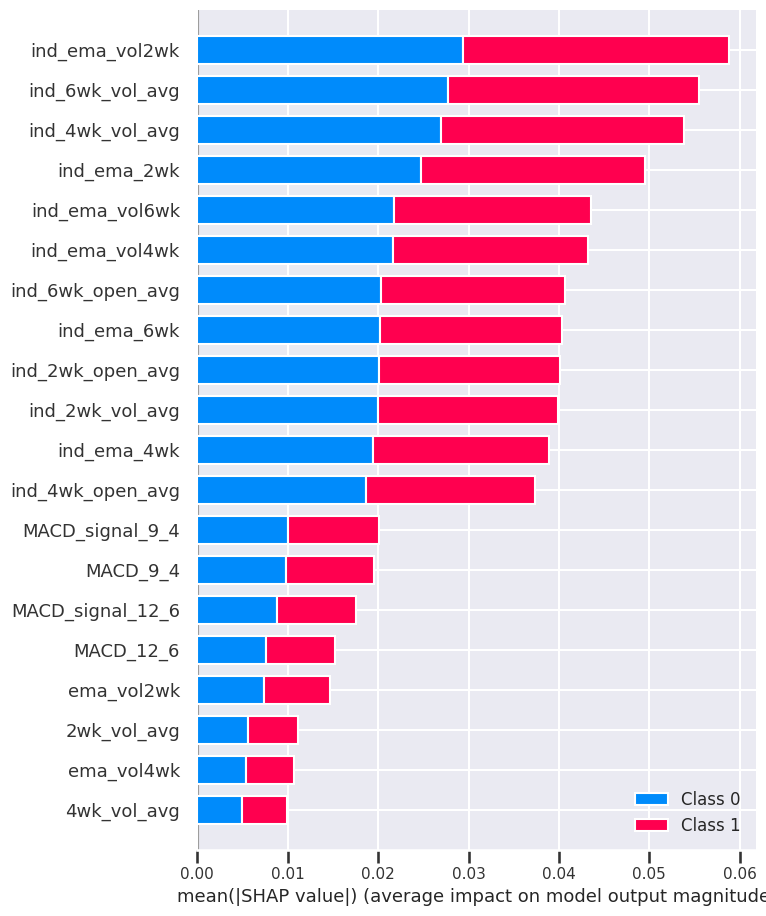

In [ ]:
shap_values = explainer.shap_values(train_sample)
shap.summary_plot(shap_values, train_sample)